In [1]:
#Importing relevant packages and King county data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
from numbers import Number
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.dummy import DummyRegressor
from scipy import stats
from scipy.stats import pearsonr
from statsmodels.tools.eval_measures import rmse
from statsmodels.formula.api import ols
import statsmodels.api as sm
%matplotlib inline


df = pd.read_csv("data/kc_house_data.csv",parse_dates=['date'], index_col=0)

# Business & Data Understanding
- Our goal in this notebook is to create an accurate model predicting prices of King county homes to help Sellers appropriately price their homes for sale on the market


- For the data in this King County notebook we decided to edit the main dataframe in order to drop the irrelevant or unreliable data and add in a custom price per square foot column to assist sellers in pricing.  We dropped all outliers in the dataset as the pricing on those outliers should be looked at on a more specific basis.


- The data we are using ranges from May 2014 to May 2015 and has 21.5k unique entries


- Limitations on this data include the timeframe being outdated, the accuracy of price, square footage, grading, zipcodes, as well as the outliers not being included

In [2]:
#Dropping columns that were suggested not to use, except date and zipcode
df.drop([ 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'waterfront'], 
        axis=1, inplace=True)

#Creating price per square foot column
df['price_sqft'] = df['price'] / df['sqft_living']

#dropping all outliers in price column, this increased our third models Rscore from .88 to .90
df = df[(np.abs(stats.zscore(df['price'])) < 3)]

# Creating our zipmaps
We decided some of the columns in this data set needed to be mapped in order to make our model perform better as well as simplify the columns for our stakeholder to interpret in a more accessible manner. 

For Zipcode we binned the zipcodes into zones which allows for more accurate modeling as well as makes the stakeholder understanding more accessible:
- Rural
- Suburbs
- Seattle

Sorted zipcodes with following sources
- website =  https://www.unitedstateszipcodes.org/wa/ 
- map = https://aqua.kingcounty.gov/gis/web/VMC/boundaries/zipcodes/zipcodes.pdf

For condition we switched these values from strings to integers for better modeling:
- Poor: 0
- Fair: 1
- Average: 2
- Good: 3
- Very Good: 4

For grade we mapped these values the same way as condition, switching them from string to ints for more interpretable data:
- 3 Poor: 3
- 4 Low: 4
- 5 Fair: 5
- 6 Low Average: 6
- 7 Average: 7
- 8 Good: 8
- 9 Better: 9
- 10 Very Good: 10
- 11 Excellent: 11
- 12 Luxury: 12
- 13 Mansion: 13

After mapping we dropped the columns we used since we created new columns for these values.



In [3]:
#Creating map for zipcodes
zip_map = {
    98001:'Suburbs', 98002:'Suburbs', 98003:'Suburbs', 98004:'Suburbs', 98005:'Suburbs',
    98006:'Suburbs', 98007:'Suburbs',98008:'Suburbs', 98010:'Rural', 98011:'Suburbs', 
    98014:'Rural', 98019:'Rural', 98022:'Rural', 98023:'Suburbs', 98024:'Rural', 
    98027:'Rural', 98028:'Suburbs', 98029:'Suburbs', 98030:'Suburbs', 98031:'Suburbs',
    98032:'Suburbs', 98033:'Suburbs', 98034:'Suburbs', 98038:'Rural', 98039:'Suburbs',
    98040:'Suburbs', 98042:'Rural', 98045:'Rural', 98052:'Suburbs', 98053:'Rural',
    98055:'Suburbs', 98056:'Suburbs', 98058:'Suburbs', 98059:'Suburbs', 98065:'Rural',
    98070:'Suburbs', 98072:'Suburbs', 98074:'Suburbs', 98075:'Suburbs', 98077:'Rural',
    98092:'Suburbs', 98102:'Seattle', 98103:'Seattle', 98105:'Seattle', 98106:'Seattle',
    98107:'Seattle', 98108:'Seattle', 98109:'Seattle', 98112:'Seattle', 98115:'Seattle', 
    98116:'Seattle', 98117:'Seattle', 98118:'Seattle', 98119:'Seattle', 98122:'Seattle',
    98125:'Seattle', 98126:'Seattle', 98133:'Seattle', 98136:'Seattle', 98144:'Seattle', 
    98146:'Seattle', 98148:'Seattle', 98155:'Seattle', 98166:'Seattle', 98168:'Seattle',
    98177:'Seattle', 98178:'Seattle', 98188:'Seattle', 98198:'Seattle', 98199:'Seattle'
    }

#creating a map for condition since there are low values of Poor and Fair compared to the other categorical variables
condition_map = {
                 'Poor': 0,
                 'Fair': 1,
                 'Average': 2,
                 'Good': 3,
                 'Very Good': 4
                }

#mapping grade map
grade_map = {
             '3 Poor': 3,
             '4 Low': 4,
             '5 Fair': 5,
             '6 Low Average': 6,
             '7 Average': 7,
             '8 Good': 8,
             '9 Better': 9,
             '10 Very Good': 10,
             '11 Excellent': 11,
             '12 Luxury': 12,
             '13 Mansion': 13
            }

# Adding maps to dataframe & dropping columns that were mapped
df['zones'] = df['zipcode'].map(zip_map)
df.drop('zipcode', axis=1, inplace=True);
df['cond_num'] = df['condition'].map(condition_map)
df.drop('condition', axis = 1, inplace=True);
df['grade_num'] = df['grade'].map(grade_map)
df.drop('grade', axis = 1, inplace=True);

# Test/Train split & Dataframes
Here we are creating our Test and Train dataframes which we will use for modeling 

In [4]:
#defining X & y
X = df.drop(columns='price', axis=1)
y = df['price']

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#creating a train df and test df
train_kch = pd.concat([X_train, y_train], axis=1)
test_kch = pd.concat([X_test, y_test], axis=1)

# Ordinal & One Hot Encoder
Here we are using Ordinal for our condition and grade column, and for the zones we are using OneHot


In [5]:
#Creating variables storing our Ordinal & One Hot Encoding columns
train_kch_cat = train_kch[['cond_num', 'grade_num']]
train_kch_zones = train_kch[['zones']]
test_kch_cat = test_kch[['cond_num', 'grade_num']]
test_kch_zones = test_kch[['zones']]

#Initializing Ordinal and One Hot
ore = OrdinalEncoder()
ore.fit(train_kch_cat)
ohe = OneHotEncoder(drop='first', sparse=False)
ohe.fit(train_kch_zones)


#Applying Ordinal and One Hot to our Train and Test
ohe_transform = ohe.transform(train_kch_zones)
zones_encoded = pd.DataFrame(ohe.fit_transform(train_kch_zones),columns=ohe.get_feature_names(),
                            index=train_kch_zones.index)


ohe_test_transform = ohe.transform(test_kch_zones)
zones_encoded_test = pd.DataFrame(ohe.fit_transform(test_kch_zones),columns=ohe.get_feature_names(),
                                 index=test_kch_zones.index)

ore_transform = ore.transform(train_kch_cat)
cat_encoded = pd.DataFrame(ore_transform, columns = ['cond_num_cat','grade_num_cat'], 
                          index=train_kch_cat.index)

ore_test_transform = ore.transform(test_kch_cat)
cat_encoded_test = pd.DataFrame(ore_test_transform, columns = ['cond_num_cat','grade_num_cat'], 
                          index=test_kch_cat.index)



# Standard Scaling
Here we are standard scaling our Test and Train data for the modeling we are about to do

In [6]:
#standard scaling the numerical values dropping categorical and target 
#training data
X_train_kch_nums = train_kch.drop(['cond_num', 'grade_num', 
                                   'zones','date', 'price'], axis=1)
y_train_kch = train_kch['price']

#testing data
X_test_kch_nums = test_kch.drop(['cond_num','grade_num', 
                                'zones','date', 'price'], axis=1)
y_test_kch = test_kch['price']

#Standardized Scaler - fit to training x
ss = StandardScaler().fit(X_train_kch_nums)


#training data - transform
X_train_scaled = pd.DataFrame(ss.transform(X_train_kch_nums), columns=X_train_kch_nums.columns, index=X_train_kch_nums.index)


#testing data - transform
X_test_scaled = pd.DataFrame(ss.transform(X_test_kch_nums), columns=X_test_kch_nums.columns, index=X_test_kch_nums.index)

In [7]:
#now can join the two separate variables - standardized and numerical
train_kch = pd.concat([X_train_scaled, cat_encoded, zones_encoded, y_train_kch],axis=1)
test_kch = pd.concat([X_test_scaled, cat_encoded_test, zones_encoded_test, y_test_kch],axis=1)

# Dummy Model
Here is our dummymodel for baseline modeling

In [8]:
#defining X & Y for trainkch df
X_train_kch = train_kch['sqft_living']
y_train_kch = train_kch['price']

#defining X and y for test_kch
X_test_kch = test_kch['sqft_living']
y_test_kch = test_kch['price']

dummy_mean = DummyRegressor(strategy='mean').fit(X_train_kch, y_train_kch)
y_predict_dummy_mean = dummy_mean.predict(X_test_kch)

In [9]:
#pulling dummy RMSE and R^2 score
dummy_regr = DummyRegressor(strategy = 'mean')
dummy_regr.fit(X_train_kch, y_train_kch)
dummy_regr.predict(X_train_kch)
dummy_regr.predict(X_test_kch)
dummy_regr.score(X_train_kch, y_train_kch)
dummy_regr.score(X_test_kch, y_test_kch)
dummy_train_RMSE = MSE(y_train_kch, dummy_regr.predict(X_train_kch),squared = False)
dummy_test_RMSE = MSE(y_test_kch, dummy_regr.predict(X_test_kch), squared = False)

print()
print(f'Baseline Model Train Score: {dummy_regr.score(X_train_kch, y_train_kch)}')
print(f'Baseline Model Train RMSE: {round(dummy_train_RMSE)}')
print()
print(f'Baseline Model Test Score: {dummy_regr.score(X_test_kch, y_test_kch)}')
print(f'Baseline Model Test RMSE: {round(dummy_test_RMSE)}')


Baseline Model Train Score: 0.0
Baseline Model Train RMSE: 259073.0

Baseline Model Test Score: -0.0006247904070475485
Baseline Model Test RMSE: 260998.0


# Modeling: Linear & Multilinear Regression
Here we have the column correlations with the price, one thing to note on this is our original correlations were much different than these final ones and you will see our process through the models on how that changed. I will identify when we get to the models that are related to this correlation value.

In [10]:
#checking correlations on price for modeling
price_corr = train_kch.corr()['price']
price_corr.abs().sort_values(ascending=False)[1:]

grade_num_cat    0.672041
sqft_living      0.664505
price_sqft       0.507379
bathrooms        0.492210
bedrooms         0.315109
floors           0.278772
sqft_lot         0.090634
yr_built         0.056489
x0_Suburbs       0.049528
cond_num_cat     0.035689
x0_Seattle       0.004917
Name: price, dtype: float64

# First Model
In this model we just compare price to square footage of the house, as you can see our R^2 value is pretty low and we would like to bring that to a higher level.  

In [11]:
#Here is our first model, just a simple linear regression between price and square feet, 
#I want to try and bring the R2 value up more
baseline_constant = train_kch['sqft_living']

baseline_model = sm.OLS(y_train_kch, sm.add_constant(baseline_constant)).fit()
baseline_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                 1.340e+04
Date:                Sun, 18 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:12:04   Log-Likelihood:            -2.3042e+05
No. Observations:               16952   AIC:                         4.608e+05
Df Residuals:                   16950   BIC:                         4.609e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.057e+05   1487.042    340.075      0.000    5.03e+05    5.09e+05
sqft_living  1.722e+05   1487.042    115.770      0.000    1.69e+05    1.75e+05
==============================================================================
Omnibus:                     2849.918   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6150.114
Skew:                           0.992   Prob(JB):                         0.00
Kurtosis:                       5.184   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Second Model
In this model we tried to add bathrooms with sqft, which at the time was our second highest correlated column, this didn't change the R2 value at all and only increased the pvalue and cond #, it did lower the F-stat. 

In [12]:
#here is our second model where I try and add the 2nd highest correlated value to the model to see if I can bring R2 up
#It appears to not have worked
baseline_constant2 = train_kch[['sqft_living', 'bathrooms']]

baseline_model2 = sm.OLS(y_train_kch, sm.add_constant(baseline_constant2)).fit()
baseline_model2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     6703.
Date:                Sun, 18 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:12:04   Log-Likelihood:            -2.3042e+05
No. Observations:               16952   AIC:                         4.608e+05
Df Residuals:                   16949   BIC:                         4.609e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.057e+05   1487.003    340.084      0.000    5.03e+05    5.09e+05
sqft_living    1.7e+05   2184.903     77.790      0.000    1.66e+05    1.74e+05
bathrooms    2990.0667   2184.903      1.369      0.171   -1292.571    7272.704
==============================================================================
Omnibus:                     2851.232   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6145.961
Skew:                           0.993   Prob(JB):                         0.00
Kurtosis:                       5.181   Cond. No.                         2.55
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Third model
Here we decided to throw in all of our Xtrain values to see what would happen with the model, this is where we want to really begin trimming and optimizing our model.  This model is after we standardized and added our Encoders, it is a really good R2 value, but some of the other values are not where we want.

Some things to note with this is our R2 value increased from .88 to .90 after we dropped the outliers from the main dataframe

In [13]:
baseline_model3 = sm.OLS(y_train_kch, sm.add_constant(X_train_scaled)).fit()
baseline_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                 2.257e+04
Date:                Sun, 18 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:12:04   Log-Likelihood:            -2.1557e+05
No. Observations:               16952   AIC:                         4.312e+05
Df Residuals:                   16944   BIC:                         4.312e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.057e+05    619.368    816.486      0.000    5.04e+05    5.07e+05
bedrooms     3342.8305    808.294      4.136      0.000    1758.491    4927.170
bathrooms    1.255e+04   1071.342     11.712      0.000    1.04e+04    1.46e+04
sqft_living  2.047e+05   1000.424    204.620      0.000    2.03e+05    2.07e+05
sqft_lot    -3136.2652    632.827     -4.956      0.000   -4376.673   -1895.858
floors        -19.9933    771.776     -0.026      0.979   -1532.754    1492.768
yr_built    -5293.1293    824.189     -6.422      0.000   -6908.626   -3677.632
price_sqft     1.8e+05    689.156    261.149      0.000    1.79e+05    1.81e+05
==============================================================================
Omnibus:                     3793.018   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39867.977
Skew:                          -0.774   Prob(JB):                         0.00
Kurtosis:                      10.352   Cond. No.                         3.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Fourth Model -relates to correlation at top of modeling section
Here is our fourth model where we tried the 2 highest correlated columns of square feet and grade. This is after we did our encoding and standardizing.  As you can see the R value of .51, which is lower than we thought it would be only increase by about 10 percent from our first model.  The F-stat is okay, but it is a pretty positivly skewed model with a skew of 1.03, which is too high.  We also have a good condition number of 31.4

In [14]:
baseline_constant4 = train_kch[['sqft_living', 'grade_num_cat']]
baseline_model4 = sm.OLS(y_train_kch, sm.add_constant(baseline_constant4)).fit()
baseline_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     8947.
Date:                Sun, 18 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:12:04   Log-Likelihood:            -2.2925e+05
No. Observations:               16952   AIC:                         4.585e+05
Df Residuals:                   16949   BIC:                         4.585e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          7.697e+04   8671.888      8.875      0.000       6e+04     9.4e+04
sqft_living    9.578e+04   2061.961     46.450      0.000    9.17e+04    9.98e+04
grade_num_cat  9.312e+04   1859.108     50.086      0.000    8.95e+04    9.68e+04
==============================================================================
Omnibus:                     3012.345   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6717.524
Skew:                           1.030   Prob(JB):                         0.00
Kurtosis:                       5.295   Cond. No.                         31.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Fifth Model
Here we tried to add in a couple more correlated columns to see if we could increase the R value more, which we did.  We also brought down the skew, but the F-stat greatly increased and Condition number stayed the same more or less. 

In [15]:
baseline_constant5 = train_kch[['sqft_living', 'grade_num_cat', 'price_sqft', 'bathrooms']]
baseline_model5 = sm.OLS(y_train_kch, sm.add_constant(baseline_constant5)).fit()
baseline_model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                 4.074e+04
Date:                Sun, 18 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:12:04   Log-Likelihood:            -2.1533e+05
No. Observations:               16952   AIC:                         4.307e+05
Df Residuals:                   16947   BIC:                         4.307e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4.072e+05   4117.698     98.879      0.000    3.99e+05    4.15e+05
sqft_living    1.913e+05   1096.699    174.418      0.000    1.89e+05    1.93e+05
grade_num_cat   2.14e+04    884.401     24.202      0.000    1.97e+04    2.31e+04
price_sqft     1.756e+05    663.280    264.791      0.000    1.74e+05    1.77e+05
bathrooms      5068.8478    923.032      5.492      0.000    3259.608    6878.087
==============================================================================
Omnibus:                     3041.576   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31241.391
Skew:                          -0.559   Prob(JB):                         0.00
Kurtosis:                       9.556   Cond. No.                         33.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Sixth Model
Here in our sixth model we wanted to try and get a good R2 number while shaving some of the columns we use, so we dropped bathrooms and still got a pretty good model, the F-stat did increase though.

In [16]:
baseline_constant6 = train_kch[['sqft_living', 'grade_num_cat', 'price_sqft']]
baseline_model6 = sm.OLS(y_train_kch, sm.add_constant(baseline_constant6)).fit()
baseline_model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                 5.422e+04
Date:                Sun, 18 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:12:04   Log-Likelihood:            -2.1535e+05
No. Observations:               16952   AIC:                         4.307e+05
Df Residuals:                   16948   BIC:                         4.307e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           4.02e+05   4011.172    100.211      0.000    3.94e+05     4.1e+05
sqft_living     1.94e+05    980.726    197.801      0.000    1.92e+05    1.96e+05
grade_num_cat  2.253e+04    860.981     26.169      0.000    2.08e+04    2.42e+04
price_sqft     1.753e+05    660.476    265.360      0.000    1.74e+05    1.77e+05
==============================================================================
Omnibus:                     3067.887   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31335.707
Skew:                          -0.569   Prob(JB):                         0.00
Kurtosis:                       9.563   Cond. No.                         33.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Final Model
Here is our final model, where we compare price to square footage, grade, price per square foot, and our zones column.  This keeps our R2 score of .9 while decreasing the F-stat and keeping skew and cond no. within a reasonable range.


One thing to note on this is when we don't drop the first catagory in our one hot encoding of zones the Condition number rises quiet significantly, if we had more time we would like to investrigate as to why that is happening. 

In [17]:
#creating a new price constant y in 1 thousands 
y_train_kch_1k = y_train_kch/1000
y_test_kch_1k = y_test_kch/1000
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,price_sqft,cond_num,grade_num
count,2.119100e+04,21191.000000,21191.000000,21191.000000,2.119100e+04,21191.000000,21191.000000,21191.000000,21191.000000,21191.000000
mean,5.070103e+05,3.356095,2.087514,2032.486103,1.482673e+04,1.486858,1970.926525,259.373918,2.408051,7.605304
std,2.594622e+05,0.917527,0.736021,836.738586,4.040095e+04,0.538297,29.285262,104.013189,0.648903,1.108906
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,1900.000000,87.588235,0.000000,3.000000
25%,3.200000e+05,3.000000,1.500000,1410.000000,5.005500e+03,1.000000,1951.000000,181.149886,2.000000,7.000000
50%,4.470000e+05,3.000000,2.250000,1890.000000,7.560000e+03,1.000000,1975.000000,242.553191,2.000000,7.000000
75%,6.276500e+05,4.000000,2.500000,2500.000000,1.049050e+04,2.000000,1996.000000,313.202602,3.000000,8.000000
max,1.640000e+06,33.000000,7.500000,7480.000000,1.651359e+06,3.500000,2015.000000,810.138889,4.000000,12.000000


In [18]:
baseline_constant7 = pd.concat([train_kch[['sqft_living', 'grade_num_cat', 'price_sqft']], zones_encoded], axis=1)
baseline_model7 = sm.OLS(y_train_kch_1k, sm.add_constant(baseline_constant7)).fit()
baseline_model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                 3.274e+04
Date:                Sun, 18 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:12:04   Log-Likelihood:                -98199.
No. Observations:               16952   AIC:                         1.964e+05
Df Residuals:                   16946   BIC:                         1.965e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           387.5389      4.336     89.371      0.000     379.039     396.038
sqft_living     194.2983      0.978    198.578      0.000     192.380     196.216
grade_num_cat    22.5401      0.870     25.920      0.000      20.836      24.245
price_sqft      174.2001      0.699    249.090      0.000     172.829     175.571
x0_Seattle       16.4548      1.916      8.587      0.000      12.699      20.211
x0_Suburbs       17.7422      1.800      9.857      0.000      14.214      21.270
==============================================================================
Omnibus:                     3071.289   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31319.499
Skew:                          -0.571   Prob(JB):                         0.00
Kurtosis:                       9.560   Cond. No.                         36.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Final Test

Running a final test on our model, all the values look similiar and within range of our final train model

In [19]:
test_constant7 = pd.concat([test_kch[['sqft_living', 'grade_num_cat', 'price_sqft']], zones_encoded_test], axis=1)
test_model7 = sm.OLS(y_test_kch_1k, sm.add_constant(test_constant7)).fit()
test_model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     8284.
Date:                Sun, 18 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:12:04   Log-Likelihood:                -24561.
No. Observations:                4239   AIC:                         4.913e+04
Df Residuals:                    4233   BIC:                         4.917e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           376.7966      8.568     43.979      0.000     359.999     393.594
sqft_living     191.2491      1.891    101.116      0.000     187.541     194.957
grade_num_cat    24.0235      1.725     13.925      0.000      20.641      27.406
price_sqft      176.6626      1.416    124.720      0.000     173.886     179.440
x0_Seattle       23.1978      3.813      6.085      0.000      15.723      30.672
x0_Suburbs       19.7455      3.602      5.482      0.000      12.684      26.807
==============================================================================
Omnibus:                      657.460   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5570.541
Skew:                          -0.481   Prob(JB):                         0.00
Kurtosis:                       8.533   Cond. No.                         36.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Conclusion
In conclusion we would recommend sellers to look into the area they are selling their home, the construction grade of their home and if they can increase that grade, and finally the square footage of the house.

Generally speaking sellers can expect for every 840 square feet increase you can expect about a 195k increase in price

For every increase in construction grade you should expect about a 23k increase in price

We got these numbers by comparing STD in our df and then comparing that to the Coef of our final model 

# Visualizations for Presentation

Here we created two visualizations for our presentation the first one is a boxplot comparing the price per square foot in each zone we created

The second one is showing price differences in grade catagory across the different zones we created

In [20]:
sns.set(style='darkgrid')

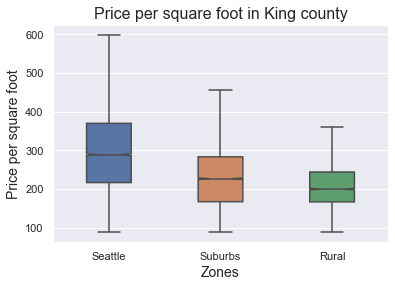

In [21]:
boxplot = sns.boxplot(x=df['zones'], y=df['price_sqft'], linewidth=1.5,notch=True,showfliers=False,
                      width =.4, order=['Seattle','Suburbs','Rural']);
boxplot.axes.set_title('Price per square foot in King county', fontsize=16)
boxplot.set_xlabel('Zones', fontsize=14)
boxplot.set_ylabel('Price per square foot', fontsize=14)
plt.show()

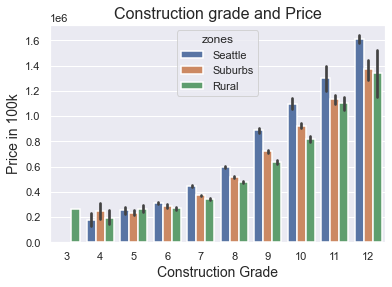

In [22]:
barplot =sns.barplot(data=df, x='grade_num', y='price', hue='zones', linewidth=1.5)
barplot.axes.set_title('Construction grade and Price', fontsize=16)
barplot.set_xlabel('Construction Grade', fontsize=14)
barplot.set_ylabel('Price in 100k', fontsize=14);

# Visualizations for models

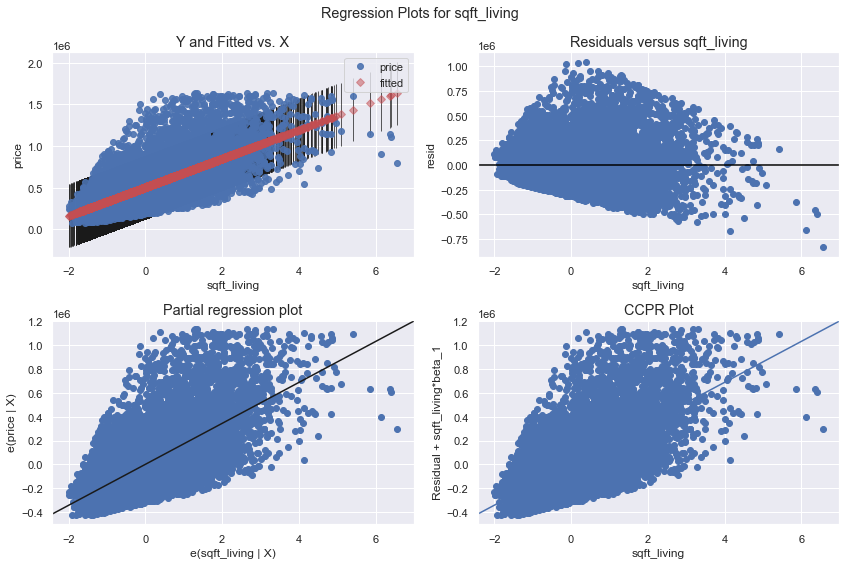

In [23]:
sm.graphics.plot_regress_exog(baseline_model, 'sqft_living', fig=plt.figure(figsize=(12, 8)));

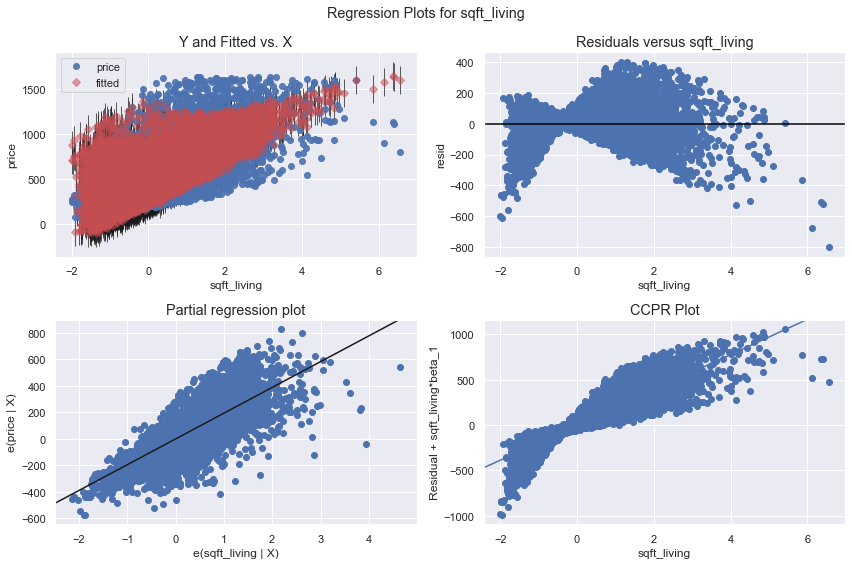

In [24]:
sm.graphics.plot_regress_exog(baseline_model7, 'sqft_living', fig=plt.figure(figsize=(12, 8)));

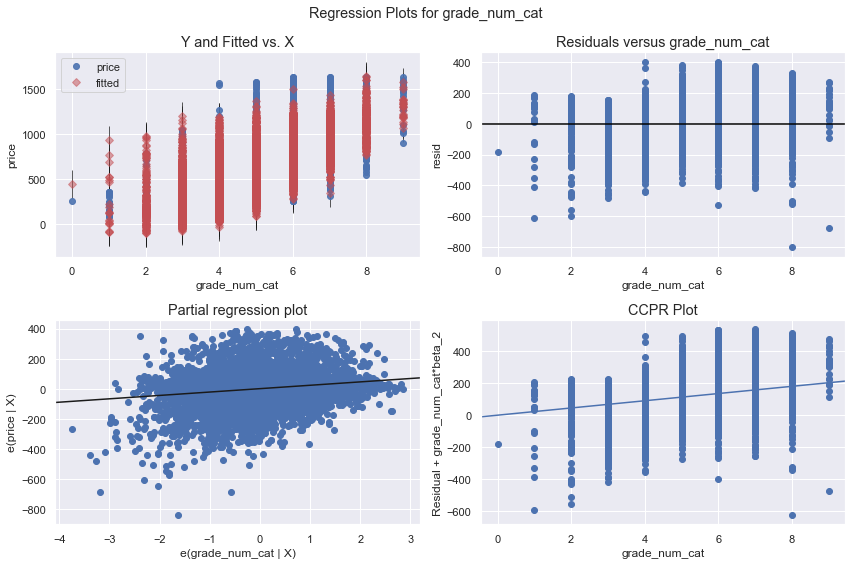

In [25]:
sm.graphics.plot_regress_exog(baseline_model7, 'grade_num_cat', fig=plt.figure(figsize=(12, 8)));

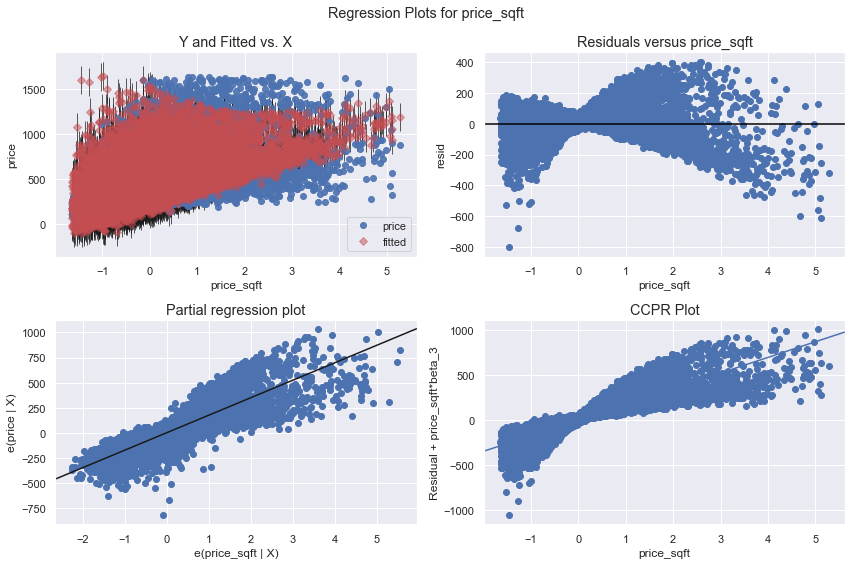

In [26]:
sm.graphics.plot_regress_exog(baseline_model7, 'price_sqft', fig=plt.figure(figsize=(12, 8)));